# 论文#48:使用mindquantum复现量子奇异值变换框架下的Grover搜索算法

原论文题目：John M. Martyn, Zane M. Rossi, Andrew K. Tan, Isaac L. Chuang, "A Grand Unification of Quantum Algorithms"

原论文链接：https://arxiv.org/abs/2105.02859

作者：张芸睿，清华大学自动化系自01班

邮箱：ZhangYR_linda@163.com



## 1. 项目介绍<a id='intro'></a>

### 1.1 经典Grover算法及其局限性

Grover搜索算法是最基础、最著名的量子算法之一，能够将搜索问题的复杂度从经典的$O(N)$提升到$O(\sqrt(N))$。然而，Grover算法也有着局限性。第一，搜索列表中的每一个元素都对应一个不同的Oracle，也就对应着一个不同的线路，当比特数增加时会影响复杂度；第二，当搜索从任意点开始时，可能出现旋转时错过目标态的情况。

### 1.2 量子信号处理(Quantum Signal Processing, QSP)


$
R_{\phi_{d-1}}(\theta) ... R_{\phi_1}(\theta) R_{\phi_0}(\theta) = 
\begin{bmatrix}
P(cos \theta) & . \\
. & . \\
\end{bmatrix}$

这里，$\phi_i$为从x轴正向开始，在x-y平面内旋转的角度，$\theta$为绕x轴旋转的角度，$d$为P的幂次。

QSP定理指出，当多项式$P(\theta)$满足一定条件时，存在一系列$\phi_i$满足以上等式。

### 1.3 量子奇异值变换（Quantum Singular Value Transformation, QSVT)

QSVT能够用矩阵的奇异值来模拟矩阵，因此能够用量子线路来实现满足一些限制条件的函数f(x)，其中f(x)对应的矩阵不一定是酉的。QSVT算法的一般流程如下：

* 构造酉矩阵$U_A$，使矩阵A（不一定为酉）位于$U_A$的左上角，即：


$U_A = 
\begin{bmatrix}
A & . & .  \\
. & . & .  \\
. & . & .  \\
\end{bmatrix}
$

$U_A=
\Pi_l A \Pi_r$

* 选取近似f(x)的、满足QSP限制条件的多项式函数P(x)，将其作用在$U_A$上。我们将这个Oracle称为$U_A'$，即：

$U_A' =
\begin{bmatrix}
P(A) & . & .  \\
. & . & .  \\
. & . & .  \\
\end{bmatrix}$

* 事实上，以上过程本质上是对矩阵A的奇异值的操作，设$A = W\Sigma V^\dagger$， 则

$U_A' =
\begin{bmatrix}
W P(\Sigma) V^\dagger & . & .  \\
. & . & .  \\
. & . & .  \\
\end{bmatrix}$

总结地说，一般的QSVT线路如下：

（插图）

来源：[Isaac Chuang - Grand Unification of Quantum Algorithms](https://www.youtube.com/watch?v=GFRojXdrVXI&t=2083s)


## 2. QSVT下的搜索算法

在搜索算法中，$ A = \langle s|t\rangle$ 是一个常数，，我们希望找到函数f(x)和多项式P(x)，使得

$f(A) \approx P(A) \rightarrow 1$

我们的任务可以分解为以下步骤：

* 找到满足QSP条件的f(x)，使得在目标x下f(x)为1

* 用切比雪夫多项式近似f(x)，得到多项式的系数

* 由这些系数计算QSP公式中的相位$\varphi_i$

* 构造酉矩阵$U_A$和对应的投影矩阵$\Pi_l$ 和 $\Pi_r$

* 建立能够在找到marked element时从$|0\rangle$翻转到$|1\rangle$的量子线路

## 3. 建立线路

引入包：

In [1]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

#Importing mindquantum libraries
# pylint: disable=W0104
from mindquantum import *
from mindquantum.simulator import Simulator


[WARNING] ME(924952:140420921496896,MainProcess):2023-10-17-19:32:48.285.890 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


首先探究两个量子比特的情况。由于需要一个用于编码的辅助比特（也是用于反转的signal qubit）和一个用于旋转的辅助比特，我们共需要四个量子比特。（事实上，无论搜索对象是几个量子比特，都只需要两个辅助比特）

In [2]:
#we have 2 system qubits
system_qubits = 2 
#following the argument above we need 2 additional qubits
nqubits = system_qubits + 2
sim = Simulator('mqvector', nqubits)  
circuit = Circuit()


两个系统比特的情况下，叠加态$|s\rangle = \frac{1}{\sqrt{2^2}}(|00\rangle + |01\rangle+ |10\rangle + |11\rangle)$。注意到由于$|s\rangle$中所有态的概率幅是相等的，无论被标记的元素是哪个，都有$A = c = \langle s|t\rangle = \frac{1}{2}$。在$2^n$维的问题中，$A = c = \langle s|t\rangle = \frac{1}{\sqrt{2^n}}$。

因此，我们希望找到$f(x)$，使得$f(c) = f(\frac{1}{2}) \rightarrow \pm 1$。对于$x = \frac{1}{2}$的情况，第三切比雪夫多项式$T_3(x)$恰好满足这一条件：


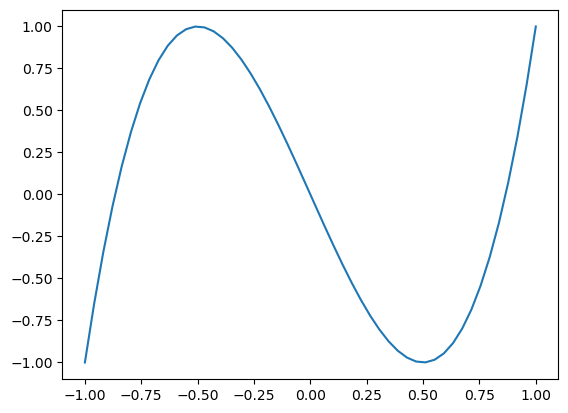

In [3]:
x = np.linspace(-1, 1)
test = np.polynomial.Chebyshev((0, 0, 0, 1)) # The 3rd Chebyshev polynomial!
y = test(x)
plt.plot(x, y)

而切比雪夫多项式$T_d(x)$对应的QSP公式中的相位为：第一个相位为$(1-d)\frac{\pi}{2}$，其他全部为$(1-d)\frac{\pi}{2}$。由此，我们可以建立量子线路：

* 定义左、右投影矩阵，分别命名为p_left和p_right：

In [4]:
# Define projectors.
# Note that p_left is actually p_right from above because the order
# of operations are reversed when equations are turned into circuits
# due to how time-flow is defined in circuit structures

# In the Qiskit implementation qubit indexes start from 0
# and the most significant qubit is the highest index
# keeping this in mind e.g for 4 nqubits = {q0,q1,q2,q3}
# q0 and q1 are the system qubits
# q2 is the signal qubit
# q3 is the ancillary rotation qubit
# nqubits-1 = 4-1 = 3 below, then corresponds to q3

def p_left(q, phi): #right projector
    qc = Circuit()
    n = q
    ctrl_range = list(range(0,n-1))

    for qubit in range(n-1): # Implement a simple multi 0-controlled
        qc += X.on(qubit)
    qc += X.on(n-1,ctrl_range) # 0-Controlled on all but the last qubits, acts on the last qubit
    for qubit in range(n-1):
        qc += X.on(qubit)


    qc += RZ(phi).on(n-1)# RZ(phi) on the last qubit

    for qubit in range(n-1): # Reverse the effect of the first multi-control
        qc += X.on(qubit)
    qc += X.on(n-1,ctrl_range)
    for qubit in range(n-1):
        qc += X.on(qubit)

    # p_left_gate = UnivMathGate('P_left',qc.matrix())
    # return p_left_gate
    return qc + BarrierGate(True)


def p_right(phi): # Left projector acts just on the signal and the ancillary qubit
    qc = Circuit()
    qc += X.on(1,0)
    qc += RZ(phi).on(1)
    qc += X.on(1,0)

    #p_right_gate = UnivMathGate('P_right',qc.matrix())
    #return p_right_gate
    return qc + BarrierGate(True)


定义U和U逆,分别命名为U和U^†：

In [5]:
#Define Oracle and the reverse-gate for
#constructing the dagger later

def U(q):
    qc = Circuit()
    n = q + 1

    for qubit in range(n-2):
        qc += H.on(qubit)

    qc += X.on(n-2, list(range(0,n-2)))

    #U_gate = UnivMathGate('U',qc.matrix())
    #return U_gate
    return qc + BarrierGate(True)


* 核心函数qsvt_search(target)如下：

In [6]:
def qsvt_search(target): # target = marked element, is a bit-string!

    systemqubits = len(target)
    nqubits = systemqubits + 2
    circuit = Circuit()

    d = (2*systemqubits) - 1

    if systemqubits > 6 and systemqubits < 10:
        for i in range(1, systemqubits - 6 + 1):
            d += 2 * i

    u = U(nqubits-1)
    #u_dag = reverse_gate(u)
    u_dag = u.hermitian() + BarrierGate(True)

    p_right_range = [nqubits-2, nqubits-1]
    u_range = list(range(0, nqubits-1))
    p_left_range = list(range(0, nqubits))


    circuit += p_left(nqubits, (1 - d) * pi)
    circuit += u


    for i in range((d - 1) // 2):
        circuit += apply(p_right(pi), p_right_range)
        circuit += u_dag
        circuit += p_left(nqubits, pi)
        circuit += u

    for i in range(len(target)): # The operation for acquiring arbitrary marked element
        bts = target [::-1]      # bitstring is reversed to be compatible with the reverse qubit order in Qiskit
        if bts[i] == '0':
            circuit += X.on(i)

    circuit += BarrierGate(True) + UN(Measure(), circuit.n_qubits)
    return circuit

###  3.1 两比特线路

标记元素为“10”的两比特线路如下：

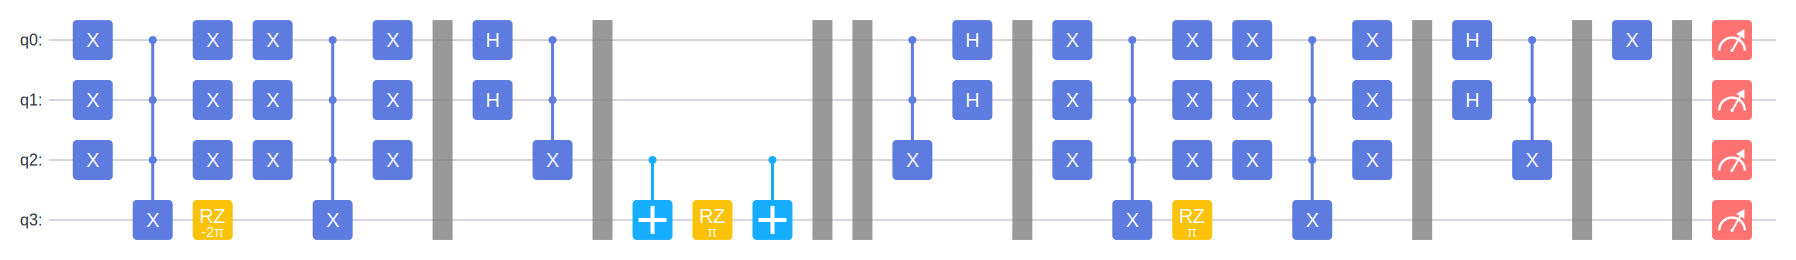

In [7]:
circuit_test = qsvt_search('10')
circuit_test.svg()

用mqvector进行模拟，搜索结果如下：

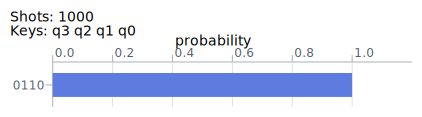

In [8]:
# pylint: disable=W0104
sim_test = Simulator('mqvector', circuit_test.n_qubits)            # 使用mqvector模拟器，命名为sim_test
#sim_test.apply_circuit(circuit_test)                      # 通过模拟器sim_test运行搭建好的量子线路circuit_test

sim_test.reset()                                      # 重置模拟器sim_test维护好的量子态，使得初始化的量子态为|00>

result = sim_test.sampling(circuit_test, shots=1000)      # 通过模拟器sim_test对量子线路circuit_test进行1000次的采样
result.svg()                                            # 打印采样结果

搜索成功率为100%。

### 3.2 三比特线路
标记元素为“110”的三比特线路如下：

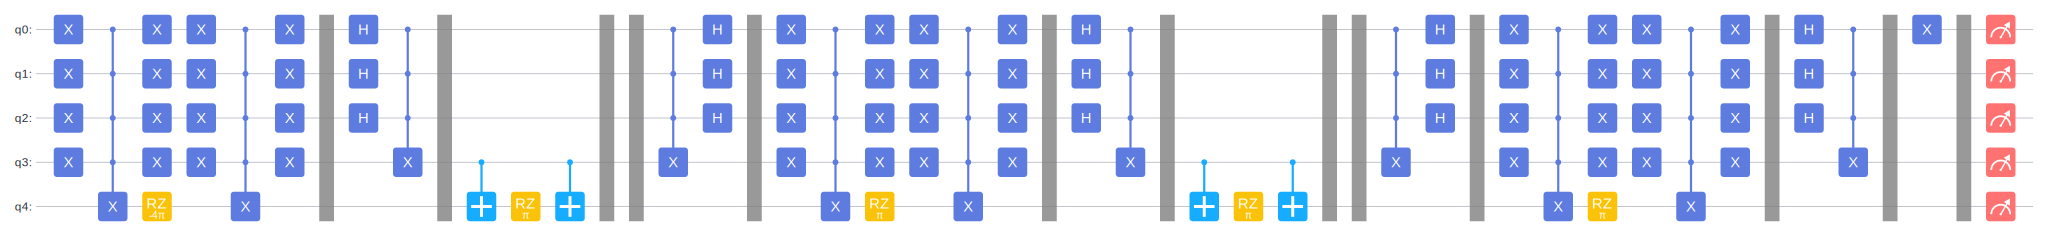

In [9]:
circuit_test = qsvt_search('110')
circuit_test.svg()

用mqvector进行模拟，搜索结果如下：

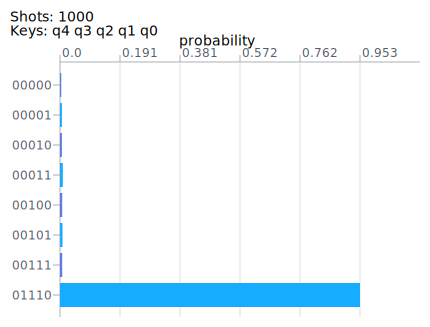

In [10]:
# pylint: disable=W0104
sim_test = Simulator('mqvector', circuit_test.n_qubits)            # 使用mqvector模拟器，命名为sim_test
#sim_test.apply_circuit(circuit_test)                      # 通过模拟器sim_test运行搭建好的量子线路circuit_test

sim_test.reset()                                      # 重置模拟器sim_test维护好的量子态，使得初始化的量子态为|000>

result = sim_test.sampling(circuit_test, shots=1000)      # 通过模拟器sim_test对量子线路circuit_test进行1000次的采样
result.svg()                                            # 打印采样结果

搜索成功率为94.7%。

### 3.3 四比特线路
标记元素为“1011”的四比特线路如下：

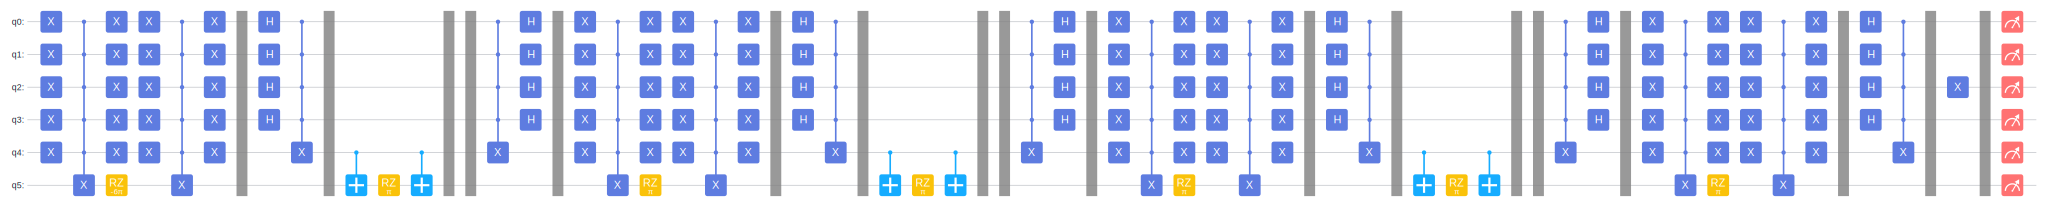

In [11]:
circuit_test = qsvt_search('1011')
circuit_test.svg()

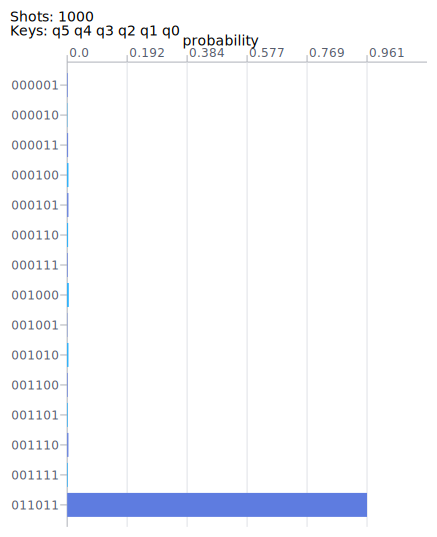

In [12]:
# pylint: disable=W0104
sim_test = Simulator('mqvector', circuit_test.n_qubits)            # 使用mqvector模拟器，命名为sim_test
#sim_test.apply_circuit(circuit_test)                      # 通过模拟器sim_test运行搭建好的量子线路circuit_test

sim_test.reset()                                      # 重置模拟器sim_test维护好的量子态，使得初始化的量子态为|0000>

result = sim_test.sampling(circuit_test, shots=1000)      # 通过模拟器sim_test对量子线路circuit_test进行1000次的采样
result.svg()                                            # 打印采样结果

搜索成功率为95.9%。

### 3.4 八比特线路

八比特线路如下：

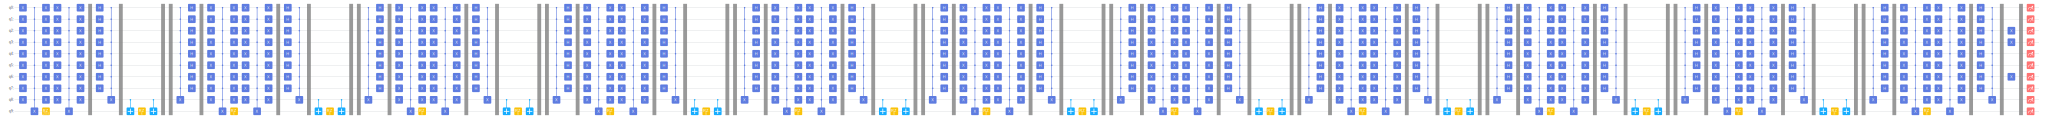

In [13]:
circuit_test = qsvt_search('10110011')
circuit_test.svg()

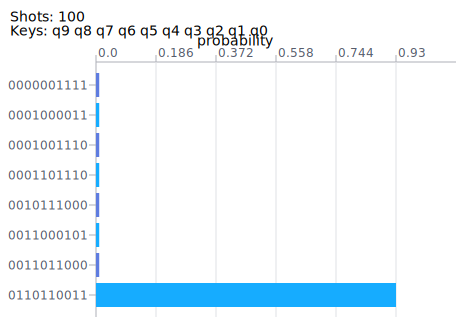

In [14]:
# pylint: disable=W0104
sim_test = Simulator('mqvector', circuit_test.n_qubits)            # 使用mqvector模拟器，命名为sim_test
#sim_test.apply_circuit(circuit_test)                      # 通过模拟器sim_test运行搭建好的量子线路circuit_test

sim_test.reset()                                      # 重置模拟器sim_test维护好的量子态，使得初始化的量子态为|000>

result = sim_test.sampling(circuit_test, shots=100)      # 通过模拟器sim_test对量子线路circuit_test进行1000次的采样
result.svg()                                            # 打印采样结果

搜索成功率为96%。

## 4. 反思与展望

（1）目前的拟合多项式和线路只支持10比特以下，且当比特数较多时，线路深度很大，运行时间和仿真时间显著变长。接下来可以研究10比特以上的情况，优化当前线路。

（2）QSVT搜索算法中，矩阵A是一个常数，因此搜索算法是QSVT中比较好实现的一个。接下来可以继续研究Shor算法、哈密顿量模拟算法等在QSVT下的实现，尝试用QSVT框架统一已知的量子算法。

## 5. 参考资料

1. John M. Martyn, Zane M. Rossi, Andrew K. Tan, Isaac L. Chuang, "A Grand Unification of Quantum Algorithms"，[https://arxiv.org/abs/2105.02859](https://arxiv.org/abs/2105.02859)

2.  Isaac Chuang - Grand Unification of Quantum Algorithms, [https://www.youtube.com/watch?v=GFRojXdrVXI&t=2083s](https://www.youtube.com/watch?v=GFRojXdrVXI&t=2083s)

3. QSVTinQiskit-2021-Europe-Hackathon-Winning-Project-:https://github.com/bartubisgin/QSVTinQiskit-2021-Europe-Hackathon-Winning-Project-